### Code For Fetching Data

In [1]:
import quandl
from yahoofinancials import YahooFinancials
import requests
import pandas as pd
from pystore import store
from datetime import datetime
from hvplot import pandas
import copy
import holoviews as hv
import numpy as np
import matplotlib.pyplot as plt

def add_close(data, tickers):
    terms = ['Value',
             'USD',
             'Hong Kong 14:00', 
             'Cash Price', 
             'Open',
            'Column 1'] + tickers
    for term in terms:
        if 'close' in data.columns:
            return data
        data.rename({term:'close'},axis=1,inplace=True)
    return data

def fetch(symbols, ticker_map, start, end, freq, collection, use_cache=True, verbose=0, **kwargs):
    """Return a key value dict of tickers and time series(dataframes)"""
    f = {}
    for symbol in symbols:
        try:
            if symbol in collection.items and use_cache:
                if verbose:
                    print("Retrieving Cache {}...".format(symbol))
                data = collection.item(symbol).to_pandas()
                assert('close' in data.columns)
            else:
                if verbose:
                    print("Fetching {}...".format(symbol))
                if symbol in ticker_map.keys():
                    source = ticker_map[symbol]['source']
                    ticker = ticker_map[symbol]['ticker']
                else:
                    source = 'yahoo'
                    ticker = symbol
                if source == 'yahoo':
                    yf = YahooFinancials(ticker)
                    data = yf.get_historical_price_data(start, end, freq)
                    data = pd.DataFrame(data[ticker]['prices'])
                elif source == 'quandl':
                    data = quandl.get(ticker, start_date=start,end_date=end,authtoken="pz51X6kcPpqth9s_J75f")
                    data = add_close(data, symbols)
                    data['date'] = pd.to_datetime(data.index)
                else:
                    print("Data Source {} not understood.".format(source))
                    raise Exception
                assert('close' in data.columns)
                collection.write(symbol,data,overwrite=True)
            f[symbol] = data
        except Exception as e:
            print("Failed to Fetch {}.".format(symbol))
            print("Data: {}".format(data))
            raise e 
    if verbose:
        print("Data Fetch Succesful.")
    return f

def format_date(sector):
    """Transforms timestamp column into pd.datetime column."""
    for symbol, df in sector.items():
        try:
            if not df['date'].dtype == 'datetime64[ns]':
                df['date'] = pd.to_datetime(df['date'].apply(datetime.fromtimestamp))
        except Exception as e:
            print("Failed to Normalize {}.".format(symbol))
            raise e 
    return sector

def fill(sector, start, end):
    """Ensure that all price series have the same index."""
    sector = {symbol:df.set_index('date')pys for symbol, df in sector.items()}
    return sector
            
def norm(sector):
    """Adds a normalized price column to all series in sector."""
    for symbol, df in sector.items():
        try:
            df['normprice'] = df['close'] / df['close'].iloc[0]
        except Exception as e:
            print("Failed to Normalize {}.".format(symbol))
            raise e 
    return sector
        
def compare(sector, start, end):
    """Returns a new dataframe with all normalized prices"""
    sector = format_date(sector)
    sector = fill(sector, start, end)
    sector = norm(sector)
    sector = {symbol:df['normprice'] for symbol,df in sector.items()}
    return pd.DataFrame(sector)

### Define Sectors

In [10]:
indexes = {
    'SP500':{'source':'yahoo','ticker':'^GSPC',},
    'Russell 2000 (Small Cap)':{'source':'yahoo','ticker':'^RUT',},
    'BSE/SENSEX (INDIA)':{'source':'quandl','ticker':'BSE/SENSEX',},
    'FTSE 100 (London)':{'source':'yahoo','ticker':'^FTSE',},
    'CAC 40 (France)':{'source':'yahoo','ticker':'^FCHI',},
    'Nikkei 225 (TOKYO)':{'source':'yahoo','ticker':'^N225',},
    'Hang Seng (Hong Kong)':{'source':'yahoo','ticker':'^HSI',},
    'Shanghai (China)':{'source':'yahoo','ticker':'^SSEC',},    
    'SP500/TSX (Canada)':{'source':'yahoo','ticker':'^GSPTSE',},    
}

crypto = {
    'BTC':{'source':'yahoo','ticker':'BTC-USD',},
    'LTC':{'source':'yahoo','ticker':'LTC-USD',},
    'ETH':{'source':'yahoo','ticker':'ETH-USD',},
    'EOS':{'source':'yahoo','ticker':'EOS-USD',},
    'BNB':{'source':'yahoo','ticker':'BNB-USD',},
    'BCH':{'source':'yahoo','ticker':'BCH-USD',},
}

fx = {
    'CAD/USD':{'source':'quandl','ticker':'BOE/XUDLCDD',}
}

tech_stocks = {
    'AAPL':{'source':'yahoo','ticker':'AAPL'}, 
    'MSFT':{'source':'yahoo','ticker':'MSFT'}, 
    'INTC':{'source':'yahoo','ticker':'INTC'},
}

mutual_funds = {
    'USAGX':{'source':'yahoo','ticker':'USAGX',
        'name': 'USAA Precious Metals and Minerals Fund',}, 
}

precious_metals =  {
    'GOLD':{'source':'quandl','ticker':"WGC/GOLD_DAILY_USD",},
    'SILV':{'source':'quandl','ticker':"LBMA/SILVER",},
    'COPP':{'source':'quandl','ticker':"ODA/PCOPP_USD",},
    'PLAT':{'source':'quandl','ticker':"JOHNMATT/PLAT",},
    'PALL':{'source':'quandl','ticker':"JOHNMATT/PALL",},
    'IRID':{'source':'quandl','ticker':"JOHNMATT/IRID",},
}

agriculture = {
    'Barley':{'source':'quandl','ticker':'ODA/PBARL_USD'},
    'Corn':{'source':'quandl','ticker':'TFGRAIN/CORN.1'},
    'Rice':{'source':'quandl','ticker':'ODA/PRICENPQ_USD'},
    'Soybeans':{'source':'quandl','ticker':'TFGRAIN/SOYBEANS.1'},
    'Wheat':{'source':'quandl','ticker':'ODA/PWHEAMT_USD'},

    'Sugar':{'source':'quandl','ticker':'CHRIS/ICE_SB1.1'},
    'Coffee Robusta':{'source':'quandl','ticker':'ODA/PCOFFROB_USD'},
    'Cotton':{'source':'quandl','ticker':'CHRIS/ICE_CT1.1'},
    'Tea':{'source':'quandl','ticker':'ODA/PTEA_USD'},
    'Milk':{'source':'quandl','ticker':'COM/MILK'},
    
    'Bananas':{'source':'quandl','ticker':'ODA/PBANSOP_USD'},
    'Oranges':{'source':'quandl','ticker':'ODA/PORANG_USD'},
    'Peanuts':{'source':'quandl','ticker':'ODA/PGNUTS_USD'},
    
    'Olive Oil':{'source':'quandl','ticker':'ODA/POLVOIL_USD'},
    'Palm Oil':{'source':'quandl','ticker':'ODA/PPOIL_USD'},
    'Sunflower Oil':{'source':'quandl','ticker':'ODA/PSUNO_USD'},
    'Rapeseed Oil':{'source':'quandl','ticker':'ODA/PROIL_USD'},
}
materials = {
    'Rubber':{'source':'quandl','ticker':'ODA/PRUBB_USD'},
    'Soft Logs':{'source':'quandl','ticker':'ODA/PLOGORE_USD'},
    'Hard Logs':{'source':'quandl','ticker':'ODA/PLOGSK_USD'},
}

oil = {
    'IMF Crude':{'source':'quandl','ticker':"ODA/POILWTI_USD",},
    'Dubai Crude':{'source':'quandl','ticker':'OPEC/ORB'},
    'Natural Gas':{'source':'quandl','ticker':'CHRIS/CME_NG1.1'},
}

sectors = [
    indexes,
    crypto,
    fx,
    tech_stocks,
    mutual_funds,
    precious_metals,
    agriculture,
    oil
]
ticker_map = {}
for s in sectors:
    ticker_map.update(s)
    
all_tickers = []
for s in sectors:
    all_tickers = all_tickers + list(s.keys())

### Define Visualizations

In [11]:
collection = store('ltf').collection('kelowna')
demo1 = {
    'symbols':[     
        'GOLD',
        'SILVER',
        'BTC', 
        'COPP',
        'AAPL', 
        'GOOG',
        'SP500',
        ],
    'start':'2012-09-15',
    'end': '2019-09-15',
    'freq': 'daily',
    'ticker_map': ticker_map,
    'collection': collection,
    'title': "Normalized Asset Comparison"
}

demo2 = copy.deepcopy(demo1)
demo2.update({
    'symbols': list(precious_metals.keys()),
    'title':"Precious Metals"
})

demo3 = copy.deepcopy(demo1)
demo3.update({
    'symbols': list(indexes.keys()),
    'title':"Indexes"
})


tech = copy.deepcopy(demo1)
tech.update({
    'symbols': list(tech_stocks.keys()),
    'title':"Tech Stocks"
})

trend_30 = {
    'symbols':[  
        'SP500',
        'F',
        'WMT',
        'HD',
        'SNE',
        'AAPL',
        'MSFT',
        'BRK-A', 
        'GOLD',
        'SILV',
        'CAD/USD',
        'IMF Crude',         
        ],
    'start':'1989-09-15',
    'end': '2019-09-15',
    'freq': 'daily',
    'ticker_map': ticker_map,
    'collection': collection,
    'title': "30 Year Capital Markets"
}


### Plot Performance

In [12]:
params = trend_30
data = fetch(all_tickers,
         params['ticker_map'],
         params['start'],
         params['end'],
         params['freq'],
         params['collection'],
         use_cache=True, 
         verbose=0,
            )
comp_start = params['start']#'2017-09-15'
comp_end   = params['end']#'2018-09-15'
comp = compare(data, comp_start, comp_end)

In [14]:
collection.write('compare',comp,overwrite=True)

In [13]:
comp

SP500  Russell 2000 (Small Cap)  BSE/SENSEX (INDIA)  \
1989-09-15  1.000000                  1.000000                 NaN   
1989-09-16  1.000000                  1.000000                 NaN   
1989-09-17  1.004840                  1.000000                 NaN   
1989-09-18  1.004840                  1.000000                 NaN   
1989-09-19  1.004318                  1.000000                 NaN   
...              ...                       ...                 ...   
2019-09-11  8.696835                  1.834567                 NaN   
2019-09-12  8.721875                  1.833822                 NaN   
2019-09-13  8.715556                  1.837397                 NaN   
2019-09-14  8.715556                  1.837397                 NaN   
2019-09-15  8.715556                  1.837397                 NaN   

            FTSE 100 (London)  CAC 40 (France)  Nikkei 225 (TOKYO)  \
1989-09-15           1.000000         1.000000            1.000000   
1989-09-16           1.000000         1.000000            1.000000   
1989-09-17           1.000000         1.000000            1.000000   
1989-09-18           1.000000         1.000000            1.000000   
1989-09-19           1.000000         1.000000            1.000000   
...                       ...              ...                 ...   
2019-09-11           1.245101         2.053758            2.367197   
2019-09-12           1.246237         2.059671            2.384936   
2019-09-13           1.250106         2.058179            2.410000   
2019-09-14           1.250106         2.058179            2.410000   
2019-09-15           1.250106         2.058179            2.410000   

            Hang Seng (Hong Kong)  Shanghai (China)  SP500/TSX (Canada)  \
1989-09-15               1.000000          1.000000            1.000000   
1989-09-16               1.000000          1.000000            1.000000   
1989-09-17               1.000000          1.000000            1.000770   
1989-09-18               1.000000          1.000000            1.000770   
1989-09-19               1.000000          1.000000            1.001206   
...                           ...               ...                 ...   
2019-09-11               2.053758          2.053758            4.263301   
2019-09-12               2.059671          2.059671            4.271565   
2019-09-13               2.058179          2.058179            4.281601   
2019-09-14               2.058179          2.058179            4.281601   
2019-09-15               2.058179          2.058179            4.281601   

                   BTC  ...   Bananas   Oranges  Peanuts  Olive Oil  Palm Oil  \
1989-09-15    1.000000  ...  1.000000  1.000000  1.00000   1.000000  1.000000   
1989-09-16    1.000000  ...  1.000000  1.000000  1.00000   1.000000  1.000000   
1989-09-17    1.000000  ...  1.000000  1.000000  1.00000   1.000000  1.000000   
1989-09-18    1.000000  ...  1.000000  1.000000  1.00000   1.000000  1.000000   
1989-09-19    1.000000  ...  1.000000  1.000000  1.00000   1.000000  1.000000   
...                ...  ...       ...       ...      ...        ...       ...   
2019-09-11  865.107214  ...  1.164286  0.787312  1.21375   0.873448  0.578271   
2019-09-12  887.571061  ...  1.164286  0.787312  1.21375   0.873448  0.578271   
2019-09-13  882.748088  ...  1.164286  0.787312  1.21375   0.873448  0.578271   
2019-09-14  882.175283  ...  1.164286  0.787312  1.21375   0.873448  0.578271   
2019-09-15  877.703790  ...  1.164286  0.787312  1.21375   0.873448  0.578271   

            Sunflower Oil  Rapeseed Oil  IMF Crude  Dubai Crude  Natural Gas  
1989-09-15       1.000000      1.000000   1.000000     1.000000     1.000000  
1989-09-16       1.000000      1.000000   1.000000     1.000000     1.000000  
1989-09-17       1.000000      1.000000   1.000000     1.000000     1.000000  
1989-09-18       1.000000      1.000000   1.000000     1.000000     1.000000  
1989-09-19       1.000000      1.000000   1.000000     1.000000 

In [9]:
title = "{} {}:{}".format(params['title'],comp_start[:4],comp_end[:4])
comp.hvplot.line(logy=True, title=title)

:Curve   [index]   (BNB-USD)

### Anayze Performance

In [7]:
daily_returns = comp.pct_change()[1:]
performance = pd.DataFrame()
performance['Annual Return'] = daily_returns.mean()*365
performance['Volatility'] = daily_returns.std(ddof=1)
performance['Sharpe Ratio'] = performance['Annual Return']/performance['Volatility']
performance.sort_values('Sharpe Ratio',ascending=False)

In [9]:
corr = daily_returns.corr()
cov  = daily_returns.cov()
xticks = list(zip(np.linspace(-0.45,0.45, len(corr.columns)), corr.columns))
yticks = list(zip(np.linspace(0.45,-0.45, len(corr.columns)), corr.columns))

In [10]:
%%opts Image [xticks=xticks yticks=yticks xrotation=45]
%%opts Image [tools=['hover'] colorbar=True title_format='Price Correlation' colorbar_position='right' height=450 width=500]
hv.Image(corr.values)

:Image   [x,y]   (z)

### Optimize a Portfolio

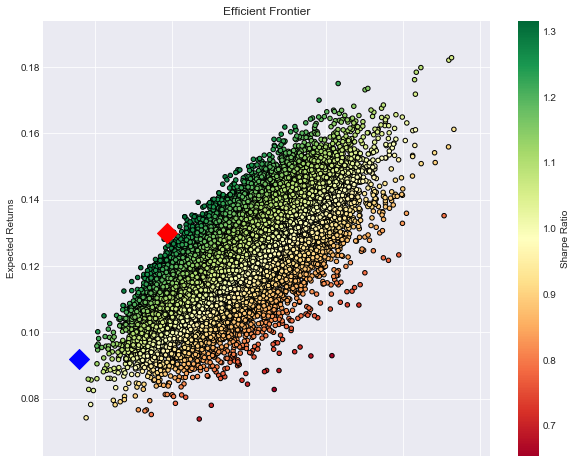

In [11]:
selected = params['symbols']

# get daily and covariance of returns of the stock
cov_daily = daily_returns.cov()
cov_annual = cov_daily * 250

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(performance)
num_portfolios = 25000

#set random seed for reproduction's sake
np.random.seed(101)

returns_annual = performance['Annual Return']

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(selected):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in selected]

# reorder dataframe columns
df = df[column_order]

# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [12]:
sp = sharpe_portfolio.drop(['Returns','Volatility','Sharpe Ratio'],axis=1)
mvp = min_variance_port.drop(['Returns','Volatility','Sharpe Ratio'],axis=1)

sp_perf = sharpe_portfolio[['Returns','Volatility','Sharpe Ratio']]
mvp_perf = min_variance_port[['Returns','Volatility','Sharpe Ratio']]

In [13]:
%%opts Bars [xrotation=45]
m = mvp.hvplot.bar(ylim=(0,1),title="Minimum Variance Portfolio")
s = sp.hvplot.bar(ylim=(0,1),title="Maximum Sharpe Portfolio")
d = (m + s).cols(1)
d

:Layout
   .Bars.I  :Bars   [index,Variable]   (value)
   .Bars.II :Bars   [index,Variable]   (value)

In [24]:
mvp_perf.index = ['Min Var Portfolio']
sp_perf.index = ['Max Sharpe Portfolio']

port_performance = pd.concat([
    performance,
    mvp_perf.rename({'Returns':'Annual Return'},axis=1),
    sp_perf.rename({'Returns':'Annual Return'},axis=1)])

apv = comp.copy()
apv['Min Variance Portfolio'] = comp @ mvp.T.values
apv['Max Sharpe Portfolio'] = comp @ sp.T.values

apv.hvplot.line(y=['Min Variance Portfolio','Max Sharpe Portfolio'],logy=False,title="Optimal Portfolio Performance")

:NdOverlay   [Variable]
   :Curve   [index]   (value)

### Run All Sectors

In [ ]:
sectors = {
    'indexes':indexes,
    'crypto':crypto,
    'mutual_funds':mutual_funds,
    'precious_metals':precious_metals,
    'agriculture':agriculture,
    'materials':materials,
    'oil':oil,
}

sector_data = {}
for sector, tmap in sectors.items():
    ticker_map.update(tmap)
    symbols = list(tmap.keys())
    params = copy.deepcopy(demo1)
    params.update({
        'symbols':symbols,
    })
    data = fetch(**params, use_cache=True, verbose=0)
    sector_data[sector] = data

In [ ]:
sector_data